我们使用softmax进行归一化，在softmax公式中，T越大，意味着标签之间的概率就能越平滑，根据Linfeng Zhang的说法，这就是一种Label Smoothing  
![](https://files.lsmcloud.top/bloga41ef067bca85d787ee0c53528302151.png)

In [5]:
import torch
import torch.nn.functional as F

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

temperature = 3

# 我们先来定义交叉熵损失函数，这里我们的归一化使用softmax
# 交叉熵源于信息论，它的物理意义是 对于基于分布P的信息片段，在错误的分布Q下预期的平均编码长度 （信息论中有一种编码长度优化，如果一个信息片段出现概率越大，我们给予其越短的编码长度，从而最节省编码资源，从这个角度也很好理解为什么-plog(p)总是小于-plog(q)了）
def cross_entropy(output: torch.Tensor, target: torch.Tensor):
    p_output = F.log_softmax(input=output/temperature, dim=1)
    p_target = F.softmax(input=target/temperature, dim=1)
    return -torch.sum(p_target * p_output, dim=1).mean() # 它们被沿着列加起来，最后做mean变成了一个单一的数（emmm 我觉得我能理解为什么有时候不同大小的batch_size训出来的model天差地别了，emmm TODO 同时我也很好奇如果只有这一个loss，反向传播是怎么进行的，感觉就像对于单一的样本，可能优化方向和力度是各有各样的，但是最后却强迫他们被统一成一个优化方向,好奇反向传播怎么进行的）

下面是对数据的简单处理过程

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


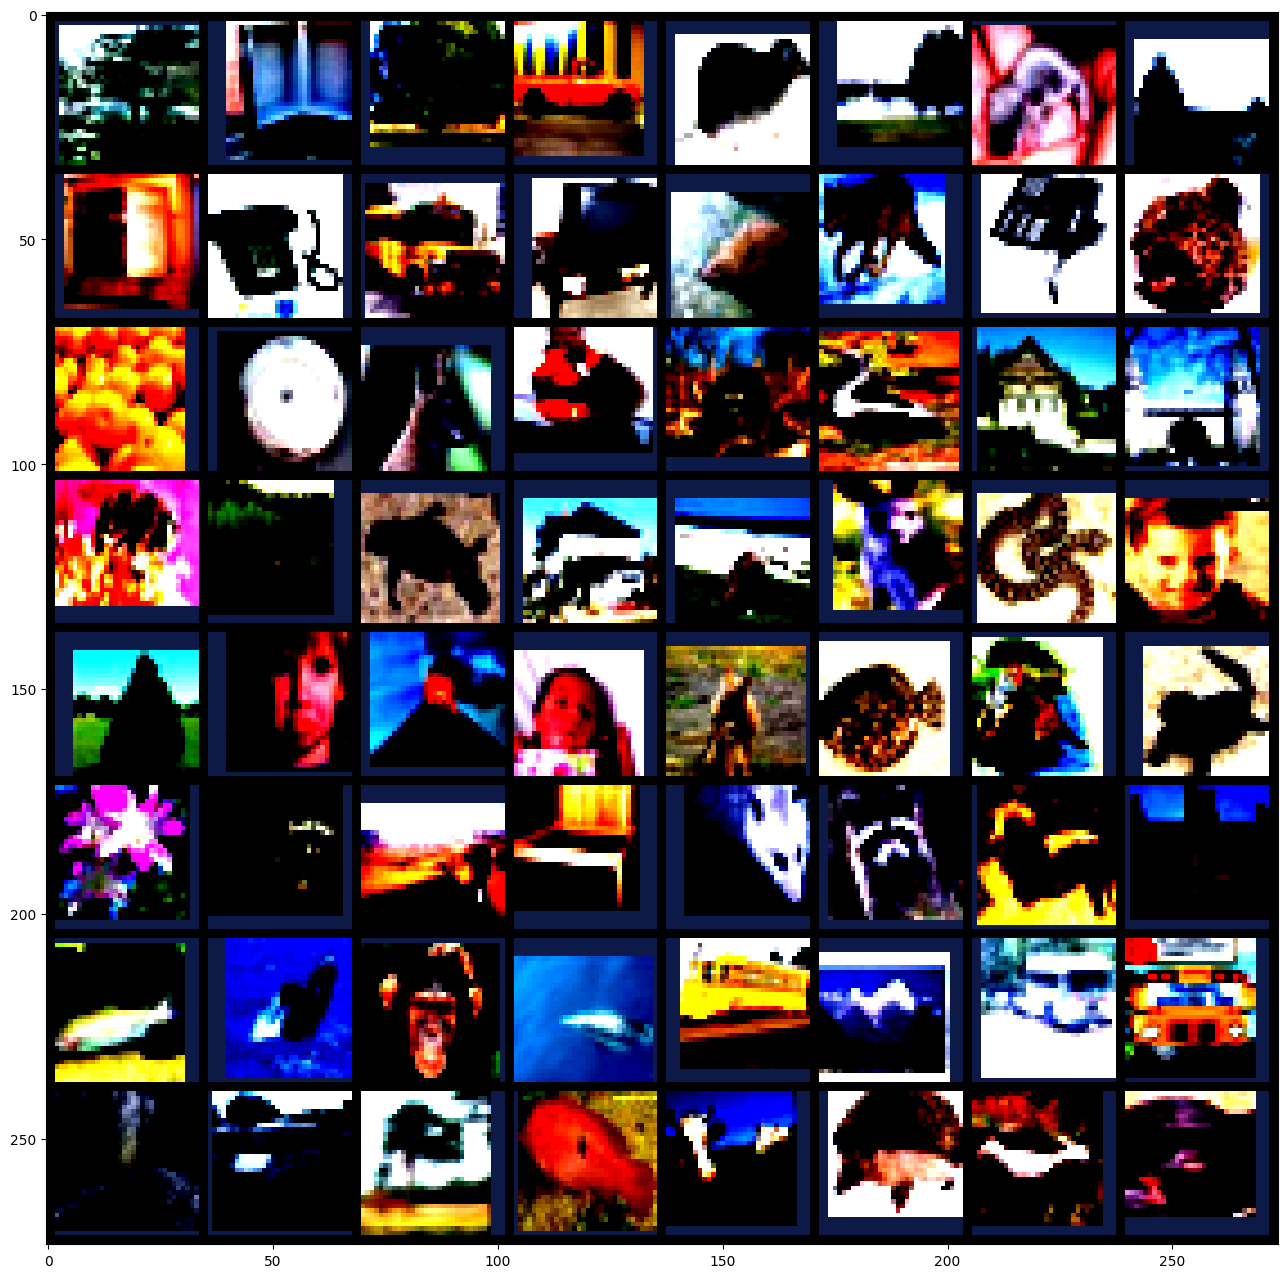

In [6]:
import torchvision.transforms as transforms
import torchvision.datasets as tvdata
import torchvision.utils as tvutil
import torch.utils.data as tdatautil
import matplotlib.pyplot as plt
import numpy as np


# 下面那组normalize值是cifar10统计出来的像素的均值和标准差，大家都认为使用这组数进行标准化可以最好的归一化数据
train_transform = transforms.Compose([transforms.RandomCrop(size=32, padding=4, fill=128), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = tvdata.CIFAR100('./data', train=True, transform=train_transform, download=True)
testset = tvdata.CIFAR100('./data', train=False, transform=test_transform, download=True)

trainloader = tdatautil.DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = tdatautil.DataLoader(dataset=testset, batch_size=64, shuffle=False)

imgs, labels = next(iter(trainloader))
plt.figure(figsize=(16,16))
plt.imshow(np.transpose(tvutil.make_grid(imgs).cpu(), (1, 2, 0)))

我们就针对我们的resnet50网络进行训练，试着蒸馏出一个效果较好的resnet18出来

In [ ]:
from resnet import resnet50
from torch.optim import Adam

model = resnet50(num_classes=100)
model.to(device)
lr = 0.1
optimizer = Adam(lr=lr, weight_decay=5e-4)
epoches = 250

for epoch in range(epoches):
    model.trian()
    if epoch in [epoches // 3, 2 * epoches // 3, epoches - 10]:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 10

    for i, data in enumerate(trainloader, 0):
        batch, labels = data
        batch.to(device)
        labels.to(device)
        out, features = model(batch)
             

